# Analyzing profiles
To study accuracy-resource tradeoff

In [1]:
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import json
from collections import defaultdict
import pandas as pd
%matplotlib notebook

PROFILE_COLUMNS = ["timestamp", "train_time", "train_loss", "train_acc", "train_num_batches",
                            "val_time", "val_loss", "val_acc", "val_num_batches",
                  "test_time", "test_loss", "test_acc", "test_num_batches"]

In [2]:
results_root = '/home/romilb/research/msr/results/profiling/waymo_phx'
result_dir = '/home/romilb/research/msr/results/profiling/waymo_phx/meta/'

# results_root = '/home/romilb/research/msr/results/profiling/20200118_1252'
# result_dir = '/home/romilb/research/msr/results/profiling/20200118_1252/meta/'

profiles_dir = os.path.join(result_dir, "profiles")
os.makedirs(result_dir, exist_ok=True)
os.makedirs(profiles_dir, exist_ok=True)
city_names = os.listdir(results_root)
if "meta" in city_names:
    city_names.remove("meta")
if "plots" in city_names:
    city_names.remove("plots")
print(city_names)

['phx-41-60', 'phx-21-40']


In [3]:
# profile: [hparamid_epochs, start_acc, end_acc, resource_time]
def get_data(json_path):
    with open(json_path) as json_file:
        data = json.load(json_file)
    task_ids, accs = zip(*data['test_acc'].items())
    task_ids = [int(x) for x in task_ids]
    return task_ids, accs

def get_profile(json_path):
    with open(json_path) as json_file:
        data = json.load(json_file)
    profile_task_map = {}
    for taskid, profile_list in data.items():
        prof = pd.DataFrame(data[taskid], columns=PROFILE_COLUMNS)
        profile_task_map[taskid] = prof
    return profile_task_map

def read_json_file(json_path):
    with open(json_path) as json_file:
        return json.load(json_file)
    
def get_subprofile_epochids(subprofile_json_path):
    data = read_json_file(subprofile_json_path)
    subprofiles_dict = list(data.values())[0]
    return [int(x) for x in subprofiles_dict.keys()]

   
def get_subprofile_default_accs(subprofile_json_path):
    data = read_json_file(subprofile_json_path)
    first_task = sorted(data.keys(), key = lambda x: int(x))[0]
    return list(data[first_task].values())[0] # This is taskwise accuracy of untrained model

def get_top5(taskwise_acc_dict, taskid, topk=5):
    data = taskwise_acc_dict[taskid]
    hp_ids = sorted(data, key=data.get, reverse=True)[:topk]
    return hp_ids, [data[i] for i in hp_ids]

# Generate regular profiles

In [14]:
# Generate profiles
for city in city_names:
    city_path = os.path.join(results_root, city)

    configs = {}

    with open(os.path.join(city_path, 'hyp_map.json')) as f:
        hyp_map = json.load(f)
    profile_files = (glob.glob(city_path + "/*_profile.json"))
    hyperparam_ids = [os.path.basename(x).split('_profile.json')[0] for x in profile_files]
    
    baseline_taskwise_acc = defaultdict(dict)
    train_taskwise_profiles = defaultdict(list)

    for hp_id in hyperparam_ids:
        profile_path = os.path.join(city_path, '{}_profile.json'.format(hp_id))
        subprofile_path = os.path.join(city_path, '{}_subprofile_test.json'.format(hp_id))
        taskwise_profiles = get_profile(profile_path)
        epochs_to_subprofile = get_subprofile_epochids(subprofile_path) # [epoch ids where subprofiled]
        untrained_accs = get_subprofile_default_accs(subprofile_path) # {task_id: acc}
        TASK_IDS = sorted(taskwise_profiles.keys(), key = lambda x: int(x))
        
        for TASK_ID in [str(x) for x in TASK_IDS]:
            profile = taskwise_profiles[TASK_ID]
            
            # Get first epoch for baseline
            baseline_taskwise_acc[TASK_ID][hp_id] = profile.loc[0]['test_acc']
            
            for e in epochs_to_subprofile:
                resource_time = sum(profile.loc[0:e]['train_time'])
                end_acc = profile.loc[e]['test_acc']
                start_acc = untrained_accs[TASK_ID]
                name = "{}_{}".format(hp_id, e)
                train_taskwise_profiles[TASK_ID].append([name, start_acc, end_acc, resource_time])
    infer_train_profile = {'taskwise_train_profiles': train_taskwise_profiles,
                           'taskwise_infer_profiles':baseline_taskwise_acc}
    with open(os.path.join(profiles_dir, "{}.json".format(city, TASK_ID)), 'w') as outfile:
        json.dump(infer_train_profile, outfile)
    #     plt.title("Profiles: {}".format(city))
    #     plt.ylabel("Accuracy")
    #     plt.xlabel("Resource Time")
    #     plt.gca().yaxis.grid(True)
    #     plt.subplots_adjust(right=0.7)
    #     plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2, title="Configurations")
        #plt.savefig(os.path.join(result_dir, '{}.png'.format(city)))

# Resource vs Accuracy Curve

<IPython.core.display.Javascript object>


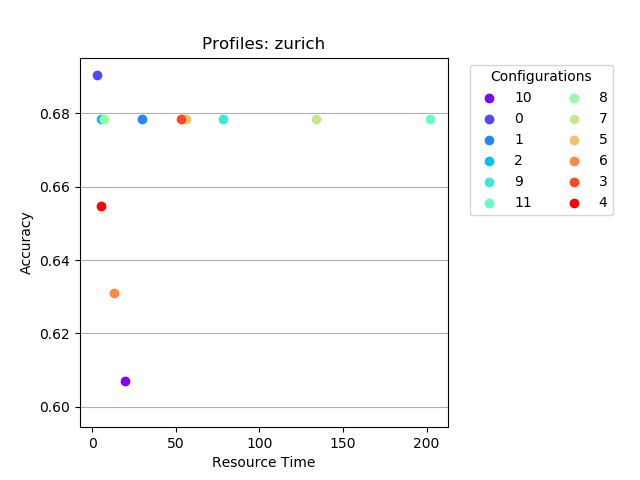

<IPython.core.display.Javascript object>


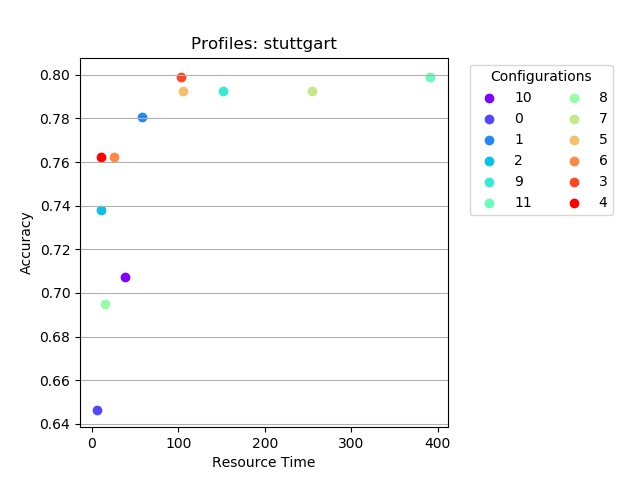

<IPython.core.display.Javascript object>


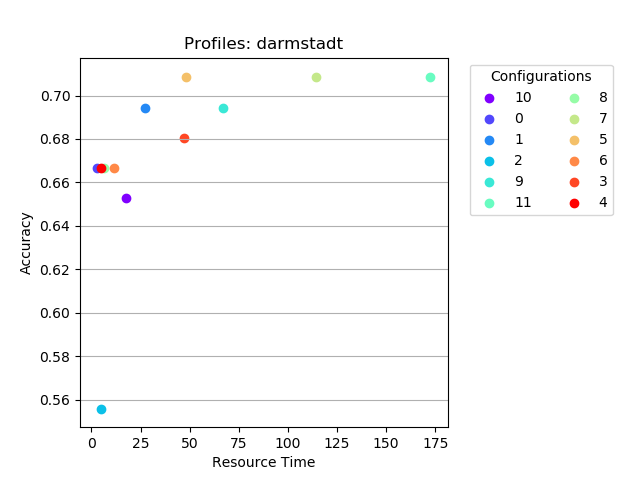

<IPython.core.display.Javascript object>


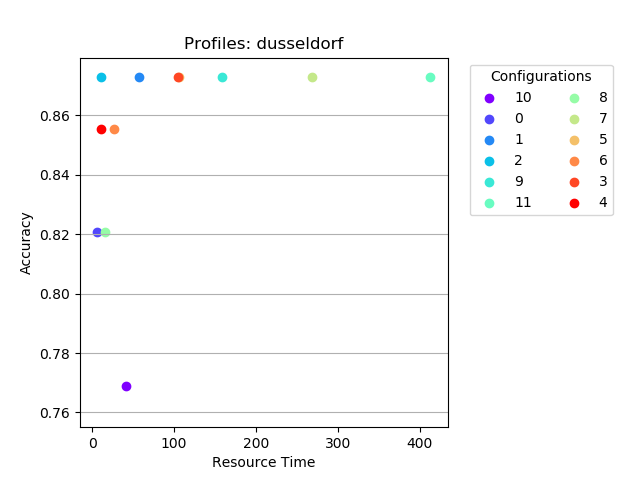

<IPython.core.display.Javascript object>


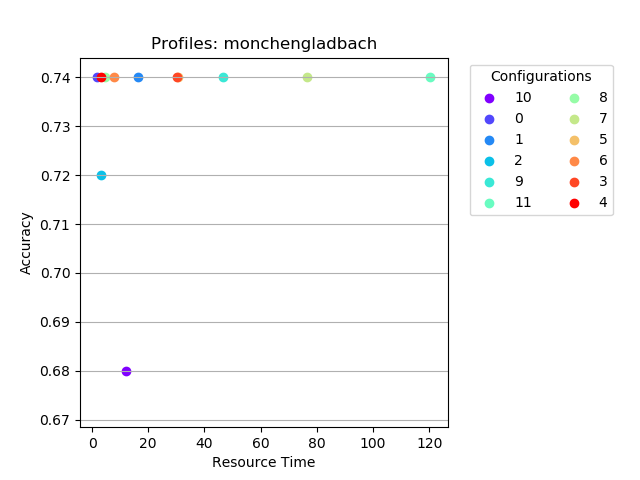

<IPython.core.display.Javascript object>


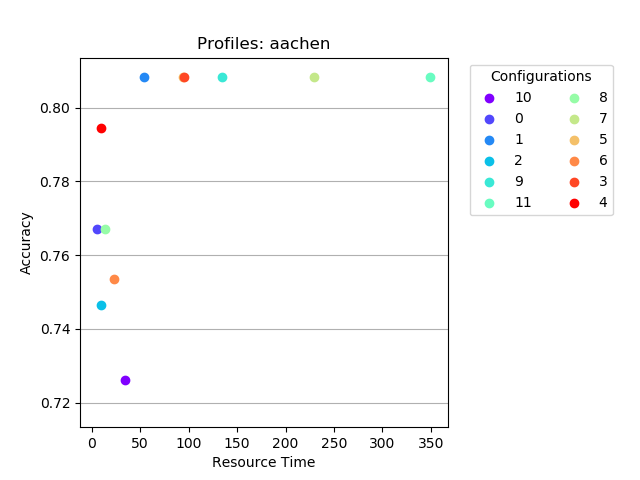

<IPython.core.display.Javascript object>


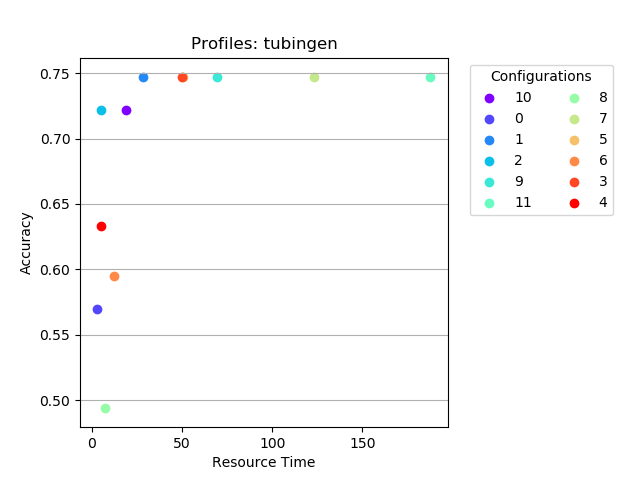

<IPython.core.display.Javascript object>


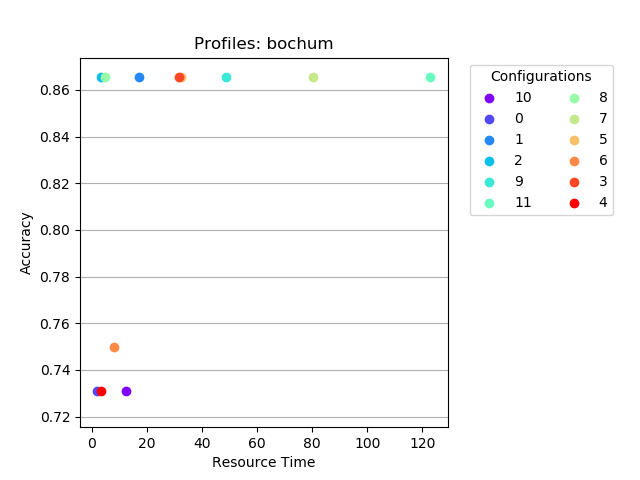

<IPython.core.display.Javascript object>


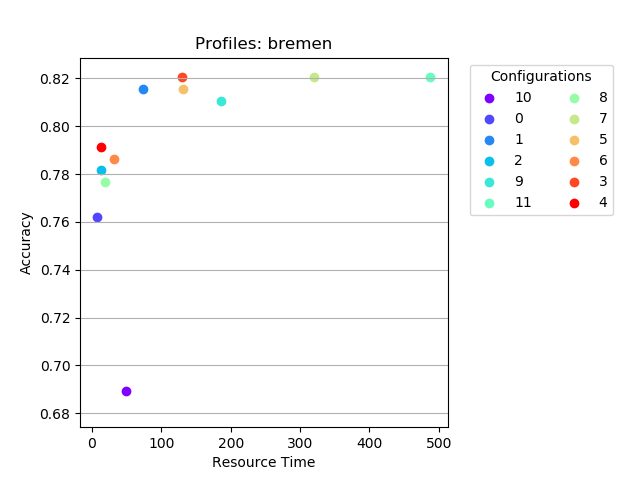

<IPython.core.display.Javascript object>


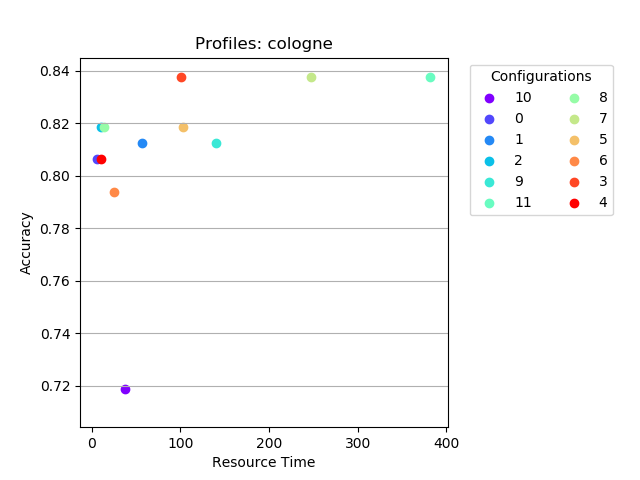

<IPython.core.display.Javascript object>


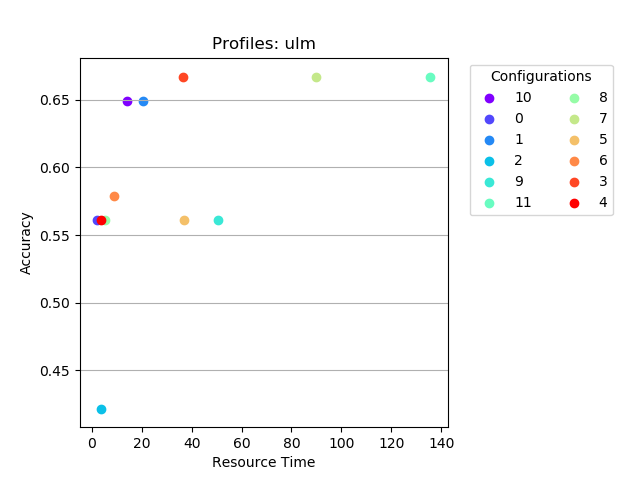

<IPython.core.display.Javascript object>


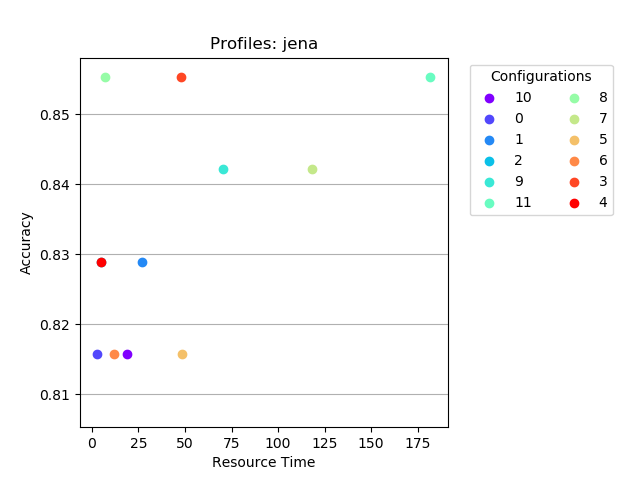

In [19]:
TASK_ID = "2"
#NUM_SUBCFGS = 3
for city in city_names:
    plt.figure()
    city_path = os.path.join(results_root, city)
    
    with open(os.path.join(city_path, 'hyp_map.json')) as f:
        hyp_map = json.load(f)
    retrain_result_files = (glob.glob(city_path + "/*_retraining_result.json"))
    hyperparam_ids = [os.path.basename(x).split('_retraining_result.json')[0] for x in retrain_result_files]
    
    colors = iter(plt.cm.rainbow(np.linspace(0,1,len(hyperparam_ids))))

    taskwise_acc = defaultdict(dict)
    for hp_id in hyperparam_ids:
        profile = get_profile(os.path.join(city_path, '{}_profile.json'.format(hp_id)))[TASK_ID]
        x = sum(profile['train_time'])
        _,accs = get_data(os.path.join(city_path, '{}_retraining_result.json'.format(hp_id)))
        y = accs[int(TASK_ID)]
        plt.scatter(x,y, label=hp_id, marker='o', color=next(colors))
        
    plt.title("Profiles: {}".format(city))
    plt.ylabel("Accuracy")
    plt.xlabel("Resource Time")
    plt.gca().yaxis.grid(True)
    plt.subplots_adjust(right=0.7)
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2, title="Configurations")
    #plt.savefig(os.path.join(result_dir, '{}.png'.format(city)))

In [32]:
profile.iloc[-1]['']

2.0310797691345215

# Generate with predictions

In [6]:

                actual_end_acc = profile.loc[e]['test_acc']results_root = '/home/romilb/research/msr/results/profiling/waymo_predictive4'
result_dir = '/home/romilb/research/msr/results/profiling/waymo_predictive4/meta'

# results_root = '/home/romilb/research/msr/results/profiling/20200118_1252'
# result_dir = '/home/romilb/research/msr/results/profiling/20200118_1252/meta/'

profiles_dir = os.path.join(result_dir, "profiles")
os.makedirs(result_dir, exist_ok=True)
os.makedirs(profiles_dir, exist_ok=True)
city_names = os.listdir(results_root)
if "meta" in city_names:
    city_names.remove("meta")
if "plots" in city_names:
    city_names.remove("plots")
print(city_names)

['phx-41-60', 'sf-45-64', 'phx-21-40']


In [10]:
# Generate profiles
for city in city_names:
    city_path = os.path.join(results_root, city)

    configs = {}

    with open(os.path.join(city_path, 'hyp_map.json')) as f:
        hyp_map = json.load(f)
    profile_files = (glob.glob(city_path + "/*_profile.json"))
    hyperparam_ids = [os.path.basename(x).split('_profile.json')[0] for x in profile_files]
    
    baseline_taskwise_acc = defaultdict(dict)
    train_taskwise_profiles = defaultdict(list)
    predicted_taskwise_profiles = defaultdict(list)

    for hp_id in hyperparam_ids:
        profile_path = os.path.join(city_path, '{}_profile.json'.format(hp_id))
        subprofile_path = os.path.join(city_path, '{}_subprofile_test.json'.format(hp_id))
        predictions_path = os.path.join(city_path, '{}_predicted_acc_1.json'.format(hp_id))
        predicted_profiles = read_json_file(predictions_path)
        taskwise_profiles = get_profile(profile_path)
        epochs_to_subprofile = get_subprofile_epochids(subprofile_path) # [epoch ids where subprofiled]
        untrained_accs = get_subprofile_default_accs(subprofile_path) # {task_id: acc}
        TASK_IDS = sorted(taskwise_profiles.keys(), key = lambda x: int(x))
        
        for TASK_ID in [str(x) for x in TASK_IDS[1:]]:
            profile = taskwise_profiles[TASK_ID]
            prediction = predicted_profiles[str(int(TASK_ID)-1)]
            
            # Get first epoch for baseline
            baseline_taskwise_acc[TASK_ID][hp_id] = profile.loc[0]['test_acc']
            for e in epochs_to_subprofile:
                resource_time = sum(profile.loc[0:e]['train_time'])
                actual_end_acc = profile.loc[e]['test_acc']
                predicted_end_acc = prediction[str(e)][TASK_ID] # ERROR - +1 wont exist always
                start_acc = untrained_accs[TASK_ID]
                name = "{}_{}".format(hp_id, e)
                train_taskwise_profiles[TASK_ID].append([name, start_acc, actual_end_acc, resource_time])
                predicted_taskwise_profiles[TASK_ID].append([name, start_acc, predicted_end_acc, resource_time])
                #TODO: ROMILB: Calculate end_acc by looking at task:task+1. Time is from task
    infer_train_profile = {'taskwise_train_profiles': train_taskwise_profiles,
                           'taskwise_infer_profiles':baseline_taskwise_acc,
                           'taskwise_predicted_profiles': predicted_taskwise_profiles}
    with open(os.path.join(profiles_dir, "{}.json".format(city, TASK_ID)), 'w') as outfile:
        json.dump(infer_train_profile, outfile)
    #     plt.title("Profiles: {}".format(city))
    #     plt.ylabel("Accuracy")
    #     plt.xlabel("Resource Time")
    #     plt.gca().yaxis.grid(True)
    #     plt.subplots_adjust(right=0.7)
    #     plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2, title="Configurations")
        #plt.savefig(os.path.join(result_dir, '{}.png'.format(city)))

# Generate profiles and predictions from subsample dataset

In [16]:
results_root = '/home/romilb/research/msr/results/profiling/20200118_1252' # WARN: This has only 3 tasks.
result_dir = '/tmp/ekya/'#'/home/romilb/research/msr/results/profiling/20200110_0807/meta/'

# results_root = '/home/romilb/research/msr/results/profiling/20200118_1252'
# result_dir = '/home/romilb/research/msr/results/profiling/20200118_1252/meta/'

profiles_dir = os.path.join(result_dir, "profiles")
os.makedirs(result_dir, exist_ok=True)
os.makedirs(profiles_dir, exist_ok=True)
city_names = os.listdir(results_root)
if "meta" in city_names:
    city_names.remove("meta")
if "plots" in city_names:
    city_names.remove("plots")
if "plot" in city_names:
    city_names.remove("plot")
if "plot_compare" in city_names:
    city_names.remove("plot_compare")
print(city_names)

['zurich', 'stuttgart', 'darmstadt', 'dusseldorf', 'monchengladbach', 'aachen', 'tubingen', 'bochum', 'bremen', 'cologne', 'ulm', 'jena', 'strasbourg', 'hamburg', 'krefeld', 'weimar']


In [17]:
def without_keys(d, keys):
    return {x: d[x] for x in d if x not in keys}

for city in city_names:
    #plt.figure()
    
    # Plot full data sample data
    city_path = os.path.join(results_root, city)
    retrain_result_files = (glob.glob(city_path + "/*_retraining_result.json"))
    hyperparam_ids = sorted([os.path.basename(x).split('_retraining_result.json')[0] for x in retrain_result_files],
                           key=int)
    
    # Read hyperparameter map
    with open(os.path.join(city_path, 'hyp_map.json')) as f:
        hyp_map = json.load(f)
        
    # Create a map of hyperparameters except "subsample" to id for comparison.  
    hyps = [without_keys(hyps, "subsample") for _, hyps in hyp_map.items()]
    hyp_unique_map = {}
    i = 0
    for h in hyps:
        if frozenset(h.items()) not in hyp_unique_map:
            hyp_unique_map[frozenset(h.items())] = i
            i+=1
    
    taskwise_acc = defaultdict(lambda: defaultdict(dict))# First key is bool for "IsSubsampled"
    for hp_id in hyperparam_ids:
        hparams = hyp_map[hp_id]
        x,y = get_data(os.path.join(city_path, '{}_retraining_result.json'.format(hp_id)))
        for t, acc in zip(x,y):
            converted_id = hyp_unique_map[frozenset(without_keys(hyp_map[hp_id], "subsample").items())]
            taskwise_acc[hparams["subsample"] < 1][t][converted_id] = acc

In [18]:
taskwise_acc

defaultdict(<function __main__.<lambda>()>,
            {True: defaultdict(dict,
                         {0: {0: 0.7509293680297398,
                           1: 0.758364312267658,
                           2: 0.7472118959107806,
                           3: 0.7509293680297398,
                           4: 0.724907063197026,
                           5: 0.7360594795539033},
                          1: {0: 0.6802973977695167,
                           1: 0.6617100371747212,
                           2: 0.6617100371747212,
                           3: 0.654275092936803,
                           4: 0.6394052044609665,
                           5: 0.7026022304832713},
                          2: {0: 0.7026022304832713,
                           1: 0.7397769516728624,
                           2: 0.7137546468401487,
                           3: 0.6319702602230483,
                           4: 0.7397769516728624,
                           5: 0.7063197026022304}}),
        

In [42]:
def get_predicted_acc(hyperparam_ids):
    

SUBSAMPLE_RATE = 0.1 # The subsampling rate used for predictions

# Generate profiles
for city in city_names:
    city_path = os.path.join(results_root, city)

    configs = {}

    with open(os.path.join(city_path, 'hyp_map.json')) as f:
        hyp_map = json.load(f)
    profile_files = (glob.glob(city_path + "/*_profile.json"))
    hyperparam_ids = [os.path.basename(x).split('_profile.json')[0] for x in profile_files]
    
    baseline_taskwise_acc = defaultdict(dict)
    train_taskwise_profiles = defaultdict(list)
    predicted_taskwise_profiles = defaultdict(list)
    
    for hp_id in hyperparam_ids:
        hparams = hyp_map[hp_id]
        hp_subsample_rate = hparams["subsample"]
        if hp_subsample_rate == SUBSAMPLE_RATE:
            print("Using hp_id {} as predictor thus not generating profile".format(hp_id))
            continue
        profile_path = os.path.join(city_path, '{}_profile.json'.format(hp_id))
        subprofile_path = os.path.join(city_path, '{}_subprofile_test.json'.format(hp_id))
        taskwise_profiles = get_profile(profile_path)
        epochs_to_subprofile = get_subprofile_epochids(subprofile_path) # [epoch ids where subprofiled]
        untrained_accs = get_subprofile_default_accs(subprofile_path) # {task_id: acc}
        TASK_IDS = sorted(taskwise_profiles.keys(), key = lambda x: int(x))
        
        for TASK_ID in [str(x) for x in TASK_IDS:
            profile = taskwise_profiles[TASK_ID]            
            # Get first epoch for baseline
            baseline_taskwise_acc[TASK_ID][hp_id] = profile.loc[0]['test_acc']
            for e in epochs_to_subprofile:
                resource_time = sum(profile.loc[0:e]['train_time'])
                actual_end_acc = profile.loc[e]['test_acc']
                predicted_end_acc = prediction[str(e)][TASK_ID] # ERROR - +1 wont exist always
                start_acc = untrained_accs[TASK_ID]
                name = "{}_{}".format(hp_id, e)
                train_taskwise_profiles[TASK_ID].append([name, start_acc, actual_end_acc, resource_time])
                predicted_taskwise_profiles[TASK_ID].append([name, start_acc, predicted_end_acc, resource_time])
                #TODO: ROMILB: Calculate end_acc by looking at task:task+1. Time is from task
    infer_train_profile = {'taskwise_train_profiles': train_taskwise_profiles,
                           'taskwise_infer_profiles':baseline_taskwise_acc,
                           'taskwise_predicted_profiles': predicted_taskwise_profiles}
    with open(os.path.join(profiles_dir, "{}.json".format(city, TASK_ID)), 'w') as outfile:
        json.dump(infer_train_profile, outfile)
    #     plt.title("Profiles: {}".format(city))
    #     plt.ylabel("Accuracy")
    #     plt.xlabel("Resource Time")
    #     plt.gca().yaxis.grid(True)
    #     plt.subplots_adjust(right=0.7)
    #     plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2, title="Configurations")
        #plt.savefig(os.path.join(result_dir, '{}.png'.format(city)))

FileNotFoundError: [Errno 2] No such file or directory: '/home/romilb/research/msr/results/profiling/20200110_0807/zurich/2_predicted_acc_1.json'

# Cityscapes predictions from Zhengxu, 02/05

# WARNING: Make sure to select data_dist or history acc based

In [51]:
results_root = '/home/romilb/research/msr/results/profiling/new_profiling/cityscapes'
result_dir = '/home/romilb/research/msr/results/profiling/new_profiling/cityscapes/meta'
pred_path = '/home/romilb/research/msr/results/profiling/new_profiling/predictions'

# results_root = '/home/romilb/research/msr/results/profiling/20200118_1252'
# result_dir = '/home/romilb/research/msr/results/profiling/20200118_1252/meta/'

profiles_dir = os.path.join(result_dir, "profiles_datadist")
os.makedirs(result_dir, exist_ok=True)
os.makedirs(profiles_dir, exist_ok=True)
city_names = os.listdir(results_root)
if "meta" in city_names:
    city_names.remove("meta")
if "plots" in city_names:
    city_names.remove("plots")
print(city_names)

['zurich', 'stuttgart', 'darmstadt', 'dusseldorf', 'monchengladbach', 'aachen', 'tubingen', 'bochum', 'bremen', 'cologne']


In [52]:
# Generate profiles
for city in city_names:
    city_path = os.path.join(results_root, city)

    configs = {}

    with open(os.path.join(city_path, 'hyp_map.json')) as f:
        hyp_map = json.load(f)
    profile_files = (glob.glob(city_path + "/*_profile.json"))
    hyperparam_ids = [os.path.basename(x).split('_profile.json')[0] for x in profile_files]
    
    baseline_taskwise_acc = defaultdict(dict)
    train_taskwise_profiles = defaultdict(list)
    predicted_taskwise_profiles = defaultdict(list)

    for hp_id in hyperparam_ids:
        profile_path = os.path.join(city_path, '{}_profile.json'.format(hp_id))
        subprofile_path = os.path.join(city_path, '{}_subprofile_test.json'.format(hp_id))
        predictions_path = os.path.join(pred_path, city, '{}_predicted_acc_2_data_dist_metric.json'.format(hp_id))
        predicted_profiles = read_json_file(predictions_path)
        taskwise_profiles = get_profile(profile_path)
        epochs_to_subprofile = get_subprofile_epochids(subprofile_path) # [epoch ids where subprofiled]
        untrained_accs = get_subprofile_default_accs(subprofile_path) # {task_id: acc}
        TASK_IDS = sorted(taskwise_profiles.keys(), key = lambda x: int(x))
        
        for TASK_ID in [str(x) for x in TASK_IDS[1:]]:
            profile = taskwise_profiles[TASK_ID]
            prediction = predicted_profiles[str(int(TASK_ID)-1)]
            
            # Get first epoch for baseline
            baseline_taskwise_acc[TASK_ID][hp_id] = profile.loc[0]['test_acc']
            for e in epochs_to_subprofile:
                resource_time = sum(profile.loc[0:e]['train_time'])
                actual_end_acc = profile.loc[e]['test_acc']
                predicted_end_acc = prediction[str(e)][TASK_ID] # ERROR - +1 wont exist always
                start_acc = untrained_accs[TASK_ID]
                name = "{}_{}".format(hp_id, e)
                train_taskwise_profiles[TASK_ID].append([name, start_acc, actual_end_acc, resource_time])
                predicted_taskwise_profiles[TASK_ID].append([name, start_acc, predicted_end_acc, resource_time])
                #TODO: ROMILB: Calculate end_acc by looking at task:task+1. Time is from task
    infer_train_profile = {'taskwise_train_profiles': train_taskwise_profiles,
                           'taskwise_infer_profiles':baseline_taskwise_acc,
                           'taskwise_predicted_profiles': predicted_taskwise_profiles}
    with open(os.path.join(profiles_dir, "{}.json".format(city, TASK_ID)), 'w') as outfile:
        json.dump(infer_train_profile, outfile)
    #     plt.title("Profiles: {}".format(city))
    #     plt.ylabel("Accuracy")
    #     plt.xlabel("Resource Time")
    #     plt.gca().yaxis.grid(True)
    #     plt.subplots_adjust(right=0.7)
    #     plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2, title="Configurations")
        #plt.savefig(os.path.join(result_dir, '{}.png'.format(city)))

# Waymo predictions from Zhengxu, 02/05

In [53]:
results_root = '/home/romilb/research/msr/results/profiling/new_profiling/waymo'
result_dir = '/home/romilb/research/msr/results/profiling/new_profiling/waymo/meta'
pred_path = '/home/romilb/research/msr/results/profiling/new_profiling/waymo'

# results_root = '/home/romilb/research/msr/results/profiling/20200118_1252'
# result_dir = '/home/romilb/research/msr/results/profiling/20200118_1252/meta/'

profiles_dir = os.path.join(result_dir, "profiles_datadist")
os.makedirs(result_dir, exist_ok=True)
os.makedirs(profiles_dir, exist_ok=True)
city_names = os.listdir(results_root)
if "meta" in city_names:
    city_names.remove("meta")
if "plots" in city_names:
    city_names.remove("plots")
print(city_names)

['phx-41-60', 'sf-65-84', 'phx-21-40']


In [54]:
# Generate profiles
for city in city_names:
    city_path = os.path.join(results_root, city)

    configs = {}

    with open(os.path.join(city_path, 'hyp_map.json')) as f:
        hyp_map = json.load(f)
    profile_files = (glob.glob(city_path + "/*_profile.json"))
    hyperparam_ids = [os.path.basename(x).split('_profile.json')[0] for x in profile_files]
    
    baseline_taskwise_acc = defaultdict(dict)
    train_taskwise_profiles = defaultdict(list)
    predicted_taskwise_profiles = defaultdict(list)

    for hp_id in hyperparam_ids:
        profile_path = os.path.join(city_path, '{}_profile.json'.format(hp_id))
        subprofile_path = os.path.join(city_path, '{}_subprofile_test.json'.format(hp_id))
        predictions_path = os.path.join(pred_path, city, '{}_predicted_acc_2_data_dist_metric.json'.format(hp_id))
        predicted_profiles = read_json_file(predictions_path)
        taskwise_profiles = get_profile(profile_path)
        epochs_to_subprofile = get_subprofile_epochids(subprofile_path) # [epoch ids where subprofiled]
        untrained_accs = get_subprofile_default_accs(subprofile_path) # {task_id: acc}
        TASK_IDS = sorted(taskwise_profiles.keys(), key = lambda x: int(x))
        
        for TASK_ID in [str(x) for x in TASK_IDS[1:]]:
            profile = taskwise_profiles[TASK_ID]
            prediction = predicted_profiles[str(int(TASK_ID))]
            
            # Get first epoch for baseline
            baseline_taskwise_acc[TASK_ID][hp_id] = profile.loc[0]['test_acc']
            for e in epochs_to_subprofile:
                resource_time = sum(profile.loc[0:e]['train_time'])
                actual_end_acc = profile.loc[e]['test_acc']
                predicted_end_acc = prediction[str(e)][TASK_ID] # ERROR - +1 wont exist always
                start_acc = untrained_accs[TASK_ID]
                name = "{}_{}".format(hp_id, e)
                train_taskwise_profiles[TASK_ID].append([name, start_acc, actual_end_acc, resource_time])
                predicted_taskwise_profiles[TASK_ID].append([name, start_acc, predicted_end_acc, resource_time])
                #TODO: ROMILB: Calculate end_acc by looking at task:task+1. Time is from task
    infer_train_profile = {'taskwise_train_profiles': train_taskwise_profiles,
                           'taskwise_infer_profiles':baseline_taskwise_acc,
                           'taskwise_predicted_profiles': predicted_taskwise_profiles}
    with open(os.path.join(profiles_dir, "{}.json".format(city, TASK_ID)), 'w') as outfile:
        json.dump(infer_train_profile, outfile)
    #     plt.title("Profiles: {}".format(city))
    #     plt.ylabel("Accuracy")
    #     plt.xlabel("Resource Time")
    #     plt.gca().yaxis.grid(True)
    #     plt.subplots_adjust(right=0.7)
    #     plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2, title="Configurations")
        #plt.savefig(os.path.join(result_dir, '{}.png'.format(city)))

# Subsampling profiles for predictions, 03/20

In [4]:
results_root = '/home/romilb/research/msr/results/profiling/new_profiling/cityscapes_subsampling'
result_dir = '/home/romilb/research/msr/results/profiling/new_profiling/cityscapes_subsampling/meta'
pred_path = '/home/romilb/research/msr/results/profiling/new_profiling/cityscapes_subsampling'

# results_root = '/home/romilb/research/msr/results/profiling/20200118_1252'
# result_dir = '/home/romilb/research/msr/results/profiling/20200118_1252/meta/'

profiles_dir = os.path.join(result_dir, "profiles_subsamppred")
os.makedirs(result_dir, exist_ok=True)
os.makedirs(profiles_dir, exist_ok=True)
city_names = os.listdir(results_root)
if "meta" in city_names:
    city_names.remove("meta")
if "plot" in city_names:
    city_names.remove("plot")
if "expt_metadata.json" in city_names:
    city_names.remove("expt_metadata.json")
print(city_names)

['bremen', 'cologne', 'ulm', 'jena', 'strasbourg', 'hamburg', 'krefeld', 'weimar', 'hanover', 'erfurt']


In [5]:
ADDITIVE_FACTOR = 0.05 # Add 5% for prediction
SUBSAMPLE_RATE = 0.05

# Generate profiles
for city in city_names:
    city_path = os.path.join(results_root, city)

    configs = {}

    with open(os.path.join(city_path, 'hyp_map.json')) as f:
        hyp_map = json.load(f)
    profile_files = (glob.glob(city_path + "/*_profile.json"))
    hyperparam_ids = [os.path.basename(x).split('_profile.json')[0] for x in profile_files]
    
    baseline_taskwise_acc = defaultdict(dict)
    train_taskwise_profiles = defaultdict(list)
    predicted_taskwise_profiles = defaultdict(list)
    
    # Create a map of the subsampling hyp_id for all hp_ids
    subsampling_hpid = {} # {hp_id: subsample_id} for each hp_id
    for hp_id in hyperparam_ids:
        hyperparams = hyp_map[hp_id]
        this_subsampling_rate =  hyperparams['subsample']
        if this_subsampling_rate == SUBSAMPLE_RATE:
            for hp_id2 in hyperparam_ids:
                h1 = {k:v for k,v in hyperparams.items() if k != 'subsample'}
                h2 = {k:v for k,v in hyp_map[hp_id2].items() if k != 'subsample'}
                if h1 == h2:
                    subsampling_hpid[hp_id2] = hp_id

    # Generate profiles
    for hp_id in hyperparam_ids:
        hyperparams = hyp_map[hp_id]
        this_subsampling_rate =  hyperparams['subsample']
        if this_subsampling_rate == SUBSAMPLE_RATE:
            #print("Skipping {}".format(hyperparams))
            continue
        subsample_id = subsampling_hpid[hp_id]
        profile_path = os.path.join(city_path, '{}_profile.json'.format(hp_id))
        subsample_profile_path = os.path.join(city_path, '{}_profile.json'.format(subsample_id))
        subprofile_path = os.path.join(city_path, '{}_subprofile_test.json'.format(hp_id))
        taskwise_profiles = get_profile(profile_path)
        taskwise_subsampling_profiles = get_profile(subsample_profile_path)
        epochs_to_subprofile = get_subprofile_epochids(subprofile_path) # [epoch ids where subprofiled]
        untrained_accs = get_subprofile_default_accs(subprofile_path) # {task_id: acc}
        TASK_IDS = sorted(taskwise_profiles.keys(), key = lambda x: int(x))
        
        taskwise_profiles_df = pd.concat(taskwise_profiles.values(), keys=taskwise_profiles.keys(), names=['task_id', 'epochs'])
        taskwise_subsampling_profiles_df = pd.concat(taskwise_subsampling_profiles.values(), keys=taskwise_subsampling_profiles.keys(), names=['task_id', 'epochs'])
        errors = []
        for TASK_ID in TASK_IDS[1:]:
            profile = taskwise_profiles_df.loc[TASK_ID]
            subsample_profile = taskwise_subsampling_profiles_df.loc[TASK_ID]
            
            cum_tasks = int(TASK_ID) - 1
            diff = taskwise_profiles_df.loc[[str(x) for x in range(0,cum_tasks)]].groupby('epochs').mean() - taskwise_subsampling_profiles_df.loc[[str(x) for x in range(0,cum_tasks)]].groupby('epochs').mean()
            
            if diff['test_acc'].empty:
                pred_val = pd.DataFrame(0, index=taskwise_profiles_df.index.levels[1], columns=['test_acc'])
            else:
                pred_val = diff
            #print("Using pred: {}".format(pred_val))
            
            # Get first epoch for baseline
            baseline_taskwise_acc[TASK_ID][hp_id] = profile.loc[0]['test_acc']
            for e in epochs_to_subprofile:
                actual_end_acc = profile.loc[e]['test_acc']
                resource_time = sum(profile.loc[0:e]['train_time'])
                predicted_end_acc = subsample_profile.loc[e]['test_acc'] + pred_val.loc[e]['test_acc'] # ERROR - +1 wont exist always
                errors.append((actual_end_acc-predicted_end_acc))
                start_acc = untrained_accs[TASK_ID]
                name = "{}_{}".format(hp_id, e)
                train_taskwise_profiles[TASK_ID].append([name, start_acc, actual_end_acc, resource_time])
                predicted_taskwise_profiles[TASK_ID].append([name, start_acc, predicted_end_acc, resource_time])
    infer_train_profile = {'taskwise_train_profiles': train_taskwise_profiles,
                           'taskwise_infer_profiles':baseline_taskwise_acc,
                           'taskwise_predicted_profiles': predicted_taskwise_profiles}
    print(np.mean(np.abs(errors)))
    with open(os.path.join(profiles_dir, "{}.json".format(city, TASK_ID)), 'w') as outfile:
        json.dump(infer_train_profile, outfile)

0.014540418828444746
0.04098434744268076
0.01942974720752502
0.05080525387542933
0.021775360164873275
0.026626735722979862
0.051540967925148735
0.04043099647266314
0.041759749167156586
0.02411113667152316


In [10]:
taskwise_profiles_df.loc['4']

,timestamp,train_time,train_loss,train_acc,train_num_batches,val_time,val_loss,val_acc,val_num_batches,test_time,test_loss,test_acc,test_num_batches
epochs,,,,,,,,,,,,,
0,1.583358e+09,0.090019,0.738081,0.766667,90,0.301992,0.763954,0.765432,324,0.065221,0.734109,0.753623,69
1,1.583358e+09,0.086464,0.702009,0.777778,90,0.298239,0.743905,0.765432,324,0.064449,0.707561,0.768116,69
2,1.583358e+09,0.086495,0.684976,0.766667,90,0.298422,0.728158,0.756173,324,0.064585,0.682854,0.768116,69
3,1.583358e+09,0.086449,0.689749,0.688889,90,0.298136,0.717074,0.756173,324,0.064794,0.661793,0.768116,69
4,1.583358e+09,0.086284,0.646747,0.733333,90,0.297391,0.705184,0.759259,324,0.064560,0.636006,0.768116,69
5,1.583358e+09,0.086203,0.636782,0.744444,90,0.298519,0.695638,0.783951,324,0.064495,0.615768,0.768116,69
6,1.583358e+09,0.086526,0.617845,0.755556,90,0.298890,0.688586,0.787037,324,0.064885,0.600090,0.768116,69
7,1.583358e+09,0.086165,0.603424,0.788889,90,0.297271,0.684541,0.790123,324,0.064533,0.587603,0.826087,69
8,1.583358e+09,0.086157,0.585051,0.777778,90,0.298249,0.682870,0.793210,324,0.064762,0.581066,0.826087,69


In [156]:
pred_val.loc[e]

0.014563106796116498

In [68]:
taskwise_profiles_df = pd.concat(taskwise_profiles.values(), keys=taskwise_profiles.keys(), names=['task_id', 'epochs'])
taskwise_subsampling_profiles_df = pd.concat(taskwise_subsampling_profiles.values(), keys=taskwise_subsampling_profiles.keys(), names=['task_id', 'epochs'])

In [115]:
cum_tasks=3
diff = taskwise_profiles_df.loc[[str(x) for x in range(0,cum_tasks)]].groupby('epochs').mean() - taskwise_subsampling_profiles_df.loc[[str(x) for x in range(0,cum_tasks)]].groupby('epochs').mean()

In [106]:
if diff['test_acc'].empty:
 diff['test_acc'] = 0

In [103]:
diff['test_acc'] = 0

In [117]:
diff['test_acc'][1]

-0.007246376811594124

In [120]:
taskwise_profiles_df.index.levels[1]

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
           dtype='int64', name='epochs')

In [142]:
diff['test_acc'].loc[2]

0.0

In [141]:
pd.DataFrame(0, index=taskwise_profiles_df.index.levels[1], columns=['test_acc']).loc[2]

test_acc    0
Name: 2, dtype: int64